In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
import plotly.offline as pyo
pyo.init_notebook_mode()
import matplotlib
%matplotlib inline

# if plotly isn't working, i did
# install nvm from
# https://github.com/nvm-sh/nvm
# and activate it
# then i did
# nvm install node
# jupyter labextension install plotlywidget

# if the jupyter widgets aren't working i have no recommendations
# only god can help you

# Import stuff
import torch
from functools import partial
import transformer_lens.utils as utils
import plotly.express as px
torch.set_grad_enabled(False)
device = utils.get_device()
# from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [ ]:
# load mamba
import mamba
from importlib import reload
reload(mamba)
model = mamba.HookedMamba.from_pretrained("state-spaces/mamba-370m", device=device)

## Full model visualizations

In [3]:

from ipywidgets import interact
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from  IPython.display import display
from einops import rearrange, repeat, einsum
from collections import defaultdict
import torch.nn.functional as F
import tqdm
import IPython

# test


import colorsys

FONT_SIZE = 60
prompt_full = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_full = model.to_tokens(prompt_full)
logits_full, activations_full = model.run_with_cache(prompt_tokens_full)
token_labels_full = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_full[0]))]

# [V,D]
embed = model.embedding.weight
V,D = embed.size()

# [V]
embed_sizes = torch.linalg.norm(embed, ord=2, dim=1)
# no divide by zero
embed_sizes[embed_sizes==0] = 1.0
# [V,D]
normalized_embed = embed / embed_sizes.view(V,1)

def tok_to_str(tok):
    if type(tok) is torch.tensor:
        tok = tok.item()
    return model.to_str_tokens(torch.tensor([tok]))[0]

#                       [K,D]    D is model.cfg.D, K is number of vecs we are comparing
def find_closest_embeds(vecs):
    if len(vecs.size()) == 1:
        vecs = vecs.view(1,D)
    K,D = vecs.size()
    
    # [K,1]
    vecs_norm = torch.linalg.norm(vecs, ord=2,dim=1, keepdim=True)
    # no divide by zero
    vecs_norm[vecs_norm==0] = 1.0
    # [K,D]          [K,D]    [K,1]
    normalized_vecs = vecs / vecs_norm

    # [V,K]         [V,D]            [D,K]
    dot_prods = normalized_embed @ normalized_vecs.T

    # [V,K]
    sorted_closest = torch.argsort(-dot_prods, dim=0)

    #       [K,V]              [K,V]
    return sorted_closest.T, dot_prods.T

if not 'diff_mag_lookup' in globals():
    global diff_mag_lookup
    diff_mag_lookup = None

# K is number of inputs, each of size D
#                          [K,D]
def compare_to_differences(vecs, top_to_keep=2):
    batch_size = 200
    lookup_batch_size = 40 # needs to be smaller

    if len(vecs.size()) == 1: # expand to K dim
        vecs = vecs.view(1,D)
    if len(vecs.size()) == 3: # remove batch dim
        if vecs.size()[0] > 1: raise Exception(f"only works for batch size = 1, you have input size {vecs.size()}")
        vecs = vecs[0]

    # normalize input
    norms = torch.linalg.norm(vecs, ord=2, dim=1, keepdim=True)
    norms[norms==0] = 1 # don't divide by 0
    vecs = vecs / norms
    
    K,D = vecs.size()
    
    top_scores = torch.zeros([K,0], device=model.cfg.device)
    top_indices = torch.zeros([K,0,2], device=model.cfg.device, dtype=torch.int64)
    
    arangeK = torch.arange(K, device=model.cfg.device)


    # We will do an optimization here
    # assume x is normalized
    # (x dot (a-b))/norm(a-b)
    # = (x dot a - x dot b)/norm(a-b)

    # thus we only need all x dot embed (small and ez)
    # and a [V,V] lookup of all the norms of a-b
    # that lookup is big, but not too big (~10GB of memory)

    global diff_mag_lookup
    if diff_mag_lookup is None:
        diff_mag_lookup = torch.zeros([V,V], device=model.cfg.device)
        print("computing diff mag lookup")
        for batch_start in tqdm.tqdm(list(range(0, V, lookup_batch_size))):
            batch_end = min(batch_start+lookup_batch_size, V)
            cur_batch_size = batch_end-batch_start
            a        = embed[batch_start:batch_end]
            b        = embed
            # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
            # because it copies the 1 axes until they match the other dim, this has the effect of:
            # res[i,j] is a[i] - b[j]
            # [batch_size, V, D]
            diffs              = a.view(cur_batch_size,1,D)-b.view(1,V,D)
            # [batch_size, V]
            norms = torch.linalg.norm(diffs, ord=2, dim=2)
            norms[norms==0.0] = 1.0 # no divide by zero!
            diff_mag_lookup[batch_start:batch_end,:] = norms
    # K,V       [K,D]   [V,D]
    dot_prods = vecs @ embed.T

    for batch_start in tqdm.tqdm(list(range(0, V, batch_size))):   
        batch_end = min(batch_start+batch_size, V)
        cur_batch_size = batch_end-batch_start
         # uses this trick https://stackoverflow.com/questions/53442069/how-to-vectorize-the-following-python-code/53442187#53442187
        # because it copies the 1 axes until they match the other dim, this has the effect of:
        # x_dot_a_minus_b[i,j] is dot_prods[:,batch_start+i] -  dot_prods[:,j]
        # [batch_size, V, D]
        # [K, batch, V]   
        x_dot_a_minus_b = dot_prods[:,batch_start:batch_end].view(K, cur_batch_size, 1) - dot_prods[:].view(K, 1, V)
        # [K, batch, V]                 [batch, V]
        x_dot_a_minus_b /= diff_mag_lookup[batch_start:batch_end,:].view(1, cur_batch_size, V)
        
        # [K,batch*V] where [k,i*V+j] = = vecs[k].dot(normalize(a[i] - b[j]))
        res2 = x_dot_a_minus_b.flatten(start_dim=1)
        # get top_to_keep for each k
        # [K,top_to_keep]
        scores, inds = torch.topk(-res2, dim=1, k=top_to_keep)
    
        # decode those into tuple indices
        # [K,top_to_keep]
        i                = inds // V + batch_start # + batch_start is because of how a is formed
        # [K,top_to_keep]
        j                = inds % V
    
        # I can't figure out how to do this and only index the right stuff
        # this way is inefficient but it's a small number of things so whatever
        # this gives us an array of size [K,top_to_keep] that has the scores of the top elements
        #scores = res2[:,top_k][arangeK, arangeK]
    
        # turn into (i, j) tuples
        # [K,top_to_keep,2]
        indices = rearrange(torch.stack([j,i]), 'data k n_keep -> k n_keep data')
    
        # append to existing ones
        # [K,top_to_keep*2] (might also just be [K,top_to_keep] if first iter)
        top_scores = torch.concatenate([top_scores, scores], dim=1)
        # [K,top_to_keep*2,2] (might also just be [K,top_to_keep,2] if first iter)
        top_indices = torch.concatenate([top_indices, indices], dim=1)
        
        # cut off so we only have top_k
        # [K,top_to_keep]
        top_k = torch.argsort(-top_scores, dim=1)[:,:top_to_keep]
        # [K,top_to_keep] 
        top_scores = top_scores[:,top_k][arangeK, arangeK]
        # [K,top_to_keep,2]
        top_indices = top_indices[:,top_k][arangeK, arangeK]
        
    #     [K,top_to_keep,2]   [K,top_to_keep]
    return top_indices,        top_scores


def make_logit_image(prs, min_pr, max_pr, words, width, height, cmap):
    cmap = matplotlib.colormaps.get_cmap(cmap)
    
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
     
    I1 = ImageDraw.Draw(img)

    def map_pr_to_color(pr):
        return cmap((pr-min_pr)/(max_pr-min_pr))
    
    cell_width = width/float(len(words[0]))
    cell_height = height/float(len(words))
    fonts = dict([(i, ImageFont.truetype('Roboto-Regular.ttf', i)) for i in range(1, FONT_SIZE+1)])
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            I1.rectangle((top_left_x, top_left_y, top_left_x+cell_width, top_left_y+cell_height), fill=(int(r*255), int(g*255), int(b*255),255))
    for y, word_list in enumerate(words):
        for x, word in enumerate(word_list):
            top_left_x = cell_width*x
            top_left_y = cell_height*y
            if word.strip() == "": continue
            font_size = FONT_SIZE
            while True:
                tl, tt, tr, tb = I1.textbbox(xy=(0,0), text=word, font=fonts[font_size])
                word_width = tr-tl
                word_height = tb-tt
                if word_width >= cell_width:
                    font_size -= 1
                else:
                    break
            # we want center of word to be at center of cell
            # by default, center of word is at
            center_of_word_x = top_left_x + word_width/2.0
            # we need some offset s.t. center is at middle of cell:
            # offset_x + center_of_word_x = top_left_x + cell_width/2.0
            # so
            offset_x = top_left_x + cell_width/2.0 - center_of_word_x
            if offset_x > 0:
                offset_x  -= 4 # fixing for space padding
            #                202         32        -100.0      204.8
            #print(word, word_width, word_height, offset_x, cell_width)
            x_pos = top_left_x + offset_x

            # same for y
            center_of_word_y = top_left_y + word_height/2.0
            offset_y = top_left_y + cell_height/2.0 - center_of_word_y
            if offset_y > 0:
                offset_y  -= 4 # fixing for space padding
            
            y_pos = top_left_y + offset_y# + cell_height//2
            color = map_pr_to_color(prs[y][x])
            r,g,b = color[0], color[1], color[2]
            h, s, v = colorsys.rgb_to_hsv(r,g,b)
            r, g, b = colorsys.hsv_to_rgb(h+0.5, 1.0-s, v)
            
            I1.text((x_pos, y_pos), word, fill=(0,0,0,255), font=fonts[font_size])
    
    return img

def display_logit_lens(title, colorbar_label, token_labels, prs, words, width, height, cmap='Purples', logits=False):
    
    prompt_len = len(prs[0])

    if logits:
        flattened = torch.tensor(prs).flatten()
        min_val, max_val = torch.min(flattened).item(), torch.max(flattened).item()
        print("min logit", min_val)
        print("max logit", max_val)
    else:
        min_val, max_val = 0.0, 1.0
    
    img = make_logit_image(min_pr=min_val, max_pr=max_val, prs=prs, words=words, width=width, height=height, cmap=cmap)
    fig, ax = plt.subplots(figsize=(10, 10))

    cbar_ax = ax.pcolor(torch.tensor([[min_val,max_val]]), cmap=cmap)
    cbar = fig.colorbar(cbar_ax)
    cbar.set_label(colorbar_label)
    
    ax.imshow(img)
    plt.title(title)
    
    x_bin_size = width/float(prompt_len)
    x_locs = [i*x_bin_size+x_bin_size//2 for i in range(len(token_labels))]
    x_labels = token_labels
    plt.xticks(x_locs, x_labels)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="right", va="center", rotation_mode="anchor")
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45, ha="left", va="center",rotation_mode="anchor")
    
    ax.set_ylabel("Layer") 
    ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
    y_bin_size = height/float(model.cfg.n_layers)
    y_locs = [i*y_bin_size+y_bin_size//2 for i in range(model.cfg.n_layers)]
    y_labels = [f'{i+1}' for i in range(model.cfg.n_layers)]
    plt.yticks(y_locs, y_labels)
    
    plt.savefig('out.png')
    plt.show()


def view_logit_lens_wrapper(label, token_labels, prompt_tokens, values_iter, lens, norm, clip_first_two):
    prompt_toks = prompt_tokens
    if len(prompt_tokens.size()) == 2: # batch
        prompt_toks = prompt_tokens[0]
    sims = []
    strs = []
    for values in values_iter:
        # [B,L,D]
        values = values.clone()
        if len(values.size()) == 2: # add batch dim if none
            values = values.view(1, values.size()[0], values.size()[1])
        if norm:
            # [B,L,D]
            values   = model.norm(values)

        if lens == DIFFERENCE_LENS:
            # [L,1,2]     [L,1]                                    [L,D]
            top_indices, top_scores      = compare_to_differences(values[0],top_to_keep=1)
            L,V = values[0].size()
            layer_words = []
            for l in range(L):
                sim = top_scores[l,0].item()
                toks = top_indices[l,0]
                token_str_a = model.to_str_tokens(torch.tensor([toks[0].item()]))[0]
                token_str_b = model.to_str_tokens(torch.tensor([toks[1].item()]))[0]
                res_str = "[" + token_str_a + " - " + token_str_b + "]"
                layer_words.append((res_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])
            print(f"layer {len(sims)}, layer_words {layer_words}")
            
        elif lens == COSINE_LENS:
            # [L,V]  [L,V]                       [L,D]
            closest, res_sims = find_closest_embeds(values[0])
            
            top_toks = closest[:,0]
            layer_words = []
            for l, top_tok in enumerate(top_toks):
                sim = res_sims[l,top_tok].item()
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                layer_words.append((token_str, sim))
            sims.append([sim for (tok, sim) in layer_words])
            strs.append([tok for (tok, sim) in layer_words])

        elif lens in [LM_HEAD_LENS, LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS]:
            # [B,L,V]
            layer_logits = model.lm_head(values)
    
            # [B,L,V]             [B,L,V]
            prs = torch.softmax(layer_logits, dim=2)
            # [B,L,V]             [B,L,V]
            top_n = torch.argsort(-layer_logits, dim=2)
    
            layer_words = []
            B,L,V = top_n.size()
            for l in range(L):
                # [1]
                top_tok = top_n[0,l,0]
                token_str = model.to_str_tokens(torch.tensor([top_tok.item()]))[0]
                # [1]
                if lens == LM_HEAD_LENS:
                    pr = prs[0,l,top_tok].item()
                elif lens == LM_HEAD_LOGIT_LENS:
                    pr = layer_logits[0,l,top_tok].item()
                elif lens == LM_HEAD_LOG_LOGIT_LENS:
                    pr = torch.sign(layer_logits[0,l,top_tok])*torch.log(torch.abs(layer_logits[0,l,top_tok]))
                    pr = pr.item()
                layer_words.append((token_str, pr))
            sims.append([pr for (tok, pr) in layer_words])
            strs.append([tok for (tok, pr) in layer_words])

    if clip_first_two:
        sims = [s[2:] for s in sims]
        strs = [s[2:] for s in strs]
        labels = token_labels[2:]
    else:
        labels = token_labels
    
    width = 2048*2
    height = 2048*2

    withOrWithout = {True: 'with', False: 'without'}[norm]
    colorbar_label = {LM_HEAD_LENS: 'pr', 
                      COSINE_LENS: 'Cosine similarity', 
                      LM_HEAD_LOGIT_LENS: 'logit',
                      LM_HEAD_LOG_LOGIT_LENS: 'log(logit)',
                      DIFFERENCE_LENS: 'Cosine similarity (to a difference between two embedding vectors)'}[lens]
    using_logits = lens in [LM_HEAD_LOGIT_LENS, LM_HEAD_LOG_LOGIT_LENS]
    display_logit_lens(title=f'{lens} Logit Lens {withOrWithout} norm for {label}', logits=using_logits, colorbar_label=colorbar_label, token_labels=labels, prs=sims, words=strs, width=width, height=height)
    

def view_logit_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_post']
   view_logit_lens_wrapper(label='resid post', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())

def view_logit_lens_resid_pre(token_labels, prompt_tokens, norm, lens, n, clip_first_two, **kwargs):
   def values_func_iter():
        for layer in range(model.cfg.n_layers):
            yield activations_full[f'blocks.{layer}.hook_resid_pre']
   view_logit_lens_wrapper(label='resid pre', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two, values_iter=values_func_iter())


def h_values_func_iter(token_labels, n, do_D=True, do_skip=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        yield proj_out

def view_h_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, **kwargs):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] {d_str}, {skip_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_values_func_iter(n=n, do_D=D, do_skip=skip, token_labels=token_labels))

def h_resid_values_func_iter(token_labels, n, do_D=True, do_skip=True, do_C=True):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,D]
    resid = activations_full[f'hook_embed'][0]
    for layer_i in range(model.cfg.n_layers):
        layer = model.blocks[layer_i]
        all_h = torch.zeros([L,E], device=model.cfg.device)
        for l in range(L):
            #  [E]                                           [B,E,N][0,:,n]
            all_h[l] = activations_full[f'blocks.{layer_i}.hook_h.{l}'][0,:,n]
        if do_C:
            # [B,L,N]
            C = activations_full[f'blocks.{layer_i}.hook_C']
            # [L]
            C_n = C[0,:,n]
            # expand C_n to be same size as all_h
            # [L,E]   [L,E]   [L,1]
            all_h   = all_h * C_n.view(L,1)
        
        if do_D:
            # [B,L,E]
            x    = activations_full[f'blocks.{layer_i}.hook_ssm_input']
            # [L,E]        [L,E]  [L,E]      [1,E]
            ssm_output = all_h + x[0,:]*layer.W_D.view(1,E)
        else:
            ssm_output = all_h

        if do_skip:
            # [B,L,E]
            skip = activations_full[f'blocks.{layer_i}.hook_skip_proj']
            # [L,E]        [L,E]                [L,E]
            model_out   = ssm_output * F.silu (skip[0,:])
        else:
            model_out   = ssm_output
        
        # [L,D]             [E->D]   [L,E]
        proj_out   = layer.out_proj(model_out)
        resid += proj_out
        yield resid


def view_h_resid_lens(token_labels, prompt_tokens, norm, lens, n, clip_first_two, skip, D, C):
    withOrWithout = {True: 'with', False: 'without'}
    d_str = withOrWithout[D] + " D"
    skip_str = withOrWithout[skip] + " skip"
    c_str = withOrWithout[C] + " C"
    view_logit_lens_wrapper(label=f'h[{n}] contributions to resid {d_str}, {skip_str}, {c_str}', norm=norm, lens=lens, token_labels=token_labels, prompt_tokens=prompt_tokens, clip_first_two=clip_first_two,
                            values_iter=h_resid_values_func_iter(n=n, do_D=D, do_skip=skip, do_C=C, token_labels=token_labels))


def top_n_outputs(token_labels, prompt_tokens, n, lens=None, norm=None, clip_first_two=None):
    # [B,L,V]
    logits = activations_full[f'hook_logits']
    top_n = torch.argsort(-logits, dim=2)
    # [B,L,V]
    prs = torch.softmax(logits, dim=2)
    L = len(token_labels)
    all_strs = []
    all_prs = []
    if n == 0:
        print("need n to be > 0")
        return
    for i in range(n):
        out_strs = []
        out_prs = []
        for l in range(L):
            top_tok = top_n[0,l,i]
            top_pr = prs[0,l,top_tok]
            out_strs.append(tok_to_str(top_tok.item()))
            out_prs.append(top_pr.item())
        all_strs.append(out_strs)
        all_prs.append(out_prs)
    
    width = 2048*2
    height = 2048*2
    
    display_logit_lens(title=f'Top {n} output tokens', logits=False, colorbar_label='pr', token_labels=token_labels, prs=all_prs, words=all_strs, width=width, height=height)

def show_C_full(token_labels, n, **kwargs):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    all_C = torch.zeros([model.cfg.n_layers, L], device=model.cfg.device)
    for layer in range(model.cfg.n_layers):
        # [L]                [B,L,N][0,:,n]
        C = activations_full[f'blocks.{layer}.hook_C'][0,:,n]
        all_C[layer,:] = C
    
    imshow(all_C, x=token_labels, xaxis="Position", yaxis="Layer", title=f"C for n={n}")
    
options_full = dict([
    ('logit_lens resid_post', partial(view_logit_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ('logit_lens resid_pre', partial(view_logit_lens_resid_pre, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h_logit_lens", partial(view_h_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("h fake logit_lens", partial(view_h_resid_lens, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("top n outputs", partial(top_n_outputs, token_labels=token_labels_full, prompt_tokens=prompt_tokens_full)),
    ("C", partial(show_C_full, token_labels=token_labels_full)),
])

def visualize_full(option, norm, lens, n, clip_first_two, skip, D, C):
    norm = norm == 'True'
    clip_first_two = clip_first_two == 'True'
    skip = skip == 'True'
    D = D == 'True'
    C = C == 'True'
    n = int(n)
    options_full[option](norm=norm, lens=lens, n=n, clip_first_two=clip_first_two, skip=skip, D=D, C=C)

COSINE_LENS = 'Cosine similarity'
LM_HEAD_LENS = 'lm_head'
LM_HEAD_LOGIT_LENS = 'lm_head logits'
LM_HEAD_LOG_LOGIT_LENS = 'lm_head log logits'
DIFFERENCE_LENS = 'Cosine similarity of differences'

text_options_full = list(options_full.keys())
display("Keep in mind only some of these settings are used for a given option")
interact(visualize_full, option=text_options_full, norm=['False', 'True'], lens=[COSINE_LENS, LM_HEAD_LENS,LM_HEAD_LOGIT_LENS,LM_HEAD_LOG_LOGIT_LENS, DIFFERENCE_LENS],n=[str(n) for n in range(model.cfg.N)], clip_first_two=['False', 'True'], skip=['True', 'False'], D=['True', 'False'], C=['True', 'False'])


'Keep in mind only some of these settings are used for a given option'

interactive(children=(Dropdown(description='option', options=('logit_lens resid_post', 'logit_lens resid_pre',…

<function __main__.visualize_full(option, norm, lens, n, clip_first_two, skip, D, C)>

## Layer-wise visualizations

In [3]:
from ipywidgets import interact
import time

prompt = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens = model.to_tokens(prompt)
logits, activations = model.run_with_cache(prompt_tokens)
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens[0]))]
task = 'IOI task'

def show_delta_1(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta_1'][0].T, x=token_labels, xaxis="Position", yaxis="D_delta", title=f"WDelta1(x)[pos, D_delta] for each stream for layer {layer}")

def show_delta(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta'][0].T, x=token_labels, xaxis="Position", yaxis="E", title=f"Deltas[Position, E] for each stream for layer {layer}")
    
def show_delta_clipped(layer, token_labels):
    imshow(activations[f'blocks.{layer}.hook_delta'][0].T[:,2:], x=token_labels[2:], xaxis="Position", yaxis="E", title=f"Deltas[2:][Position, E] for each stream for layer {layer}")
    
def show_A(layer):
    # [E,N]
    A = -torch.exp(model.blocks[layer].A_log)
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="E", yaxis="N", title=f"A[E,N] for layer {layer} (A=-exp(A_log), A_log is learned param)")
    
def show_exp_A(layer):
    # note, these will all be < 1 because of the way A is computed via A = -exp(A_log)
    # [E,N]
    A = torch.exp(-torch.exp(model.blocks[layer].A_log))
    CHUNK_SIZE = model.cfg.N*8
    for chunk_start in range(0, model.cfg.E, CHUNK_SIZE):
        imshow(A[chunk_start:chunk_start+CHUNK_SIZE].T, x=[str(x) for x in range(chunk_start, chunk_start+CHUNK_SIZE)],xaxis="E", yaxis="N", title=f"exp(A)[E,N] for layer {layer} (A=-exp(A_log), A_log is learned param)")
    
def show_h(layer, token_labels):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    all_h = torch.zeros([L,E,N])
    for l in range(L):
        all_h[l] = activations[f'blocks.{layer}.hook_h.{l}'][0]
    for n in range(N):
        imshow(all_h[:,:,n].T, x=token_labels, xaxis="Position", yaxis="E", title=f"h for layer {layer} with n={n}")
        time.sleep(0.1)

def show_C(layer, token_labels):
    L = len(token_labels)
    E,N = model.cfg.E, model.cfg.N
    # [L,N]                [B,L,N][0]
    C = activations[f'blocks.{layer}.hook_C'][0]
    imshow(C.T, x=token_labels, xaxis="Position", yaxis="N", title=f"C for layer {layer}")
    
options = dict([
    ('delta_1', partial(show_delta_1, token_labels=token_labels)),
    ('delta', partial(show_delta, token_labels=token_labels)),
    ('delta_clipped', partial(show_delta_clipped, token_labels=token_labels)),
    ('A', show_A),
    ('exp(A)', show_exp_A),
    ('h', partial(show_h, token_labels=token_labels)),
    ('C', partial(show_C, token_labels=token_labels)),
])

def visualize(layer, option):
    options[option](layer)

    
text_options = list(options.keys())
interact(visualize, layer=range(model.cfg.n_layers), option=text_options)

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, option)>

## Stream-wise visualizations

In [5]:
from ipywidgets import interact

prompt_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_e = model.to_tokens(prompt_e)
logits_e, activations_e = model.run_with_cache(prompt_tokens_e)
token_labels_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_e[0]))]

def show_delta_e(e, token_labels_e):
    L = len(token_labels_e)
    delta_e = torch.zeros([L,model.cfg.n_layers])
    for layer in range(model.cfg.n_layers):
        # [B,L,E]
        delta   =    activations[f'blocks.{layer}.hook_delta']
        #                      [L]
        delta_e[:,layer] = delta[0,:,e]
    imshow(delta_e.T, x=token_labels_e, xaxis="Position", yaxis="Layer", title=f"Deltas[Position,e] for stream {e} on the IOI Task")

def show_delta_e_clipped(e, token_labels_e):
    L = len(token_labels_e)
    delta_e = torch.zeros([L-2,model.cfg.n_layers])
    for layer in range(model.cfg.n_layers):
        # [B,L,E]
        delta   =    activations[f'blocks.{layer}.hook_delta']
        #                      [L]
        delta_e[:,layer] = delta[0,2:,e]
    imshow(delta_e.T, x=token_labels_e[2:], xaxis="Position", yaxis="Layer", title=f"Deltas[2:][Position,e] for stream {e} on the IOI Task")

def show_A_e(e):
    A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        A_e[:,layer] = A[e]
    imshow(A_e, xaxis="Layer", yaxis="N", title=f"A for stream {e} (A=-exp(A_log)[N], A_log is learned param)")
    
def show_exp_A_e(e):
    exp_A_e = torch.zeros([model.cfg.N, model.cfg.n_layers])
    
    for layer in range(model.cfg.n_layers):
        # [E,N]
        A = -torch.exp(model.blocks[layer].A_log)
        exp_A_e[:,layer] = torch.exp(A[e])
    imshow(exp_A_e, xaxis="Layer", yaxis="N", title=f"exp(A)[N] for stream {e} (A=-exp(A_log), A_log is learned param)")
    
    
options_e = dict([
    ('delta', partial(show_delta_e, token_labels_e=token_labels_e)),
    ('delta_clipped', partial(show_delta_e_clipped, token_labels_e=token_labels_e)),
    ('A', show_A_e),
    ('exp(A)', show_exp_A_e),
])



def visualize(e, option):
    options_e[option](e)
text_options_e = list(options_e.keys())
interact(visualize, e=range(model.cfg.E), option=text_options_e)

interactive(children=(Dropdown(description='e', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.visualize(e, option)>

## Layer-wise and Stream-wise visualizations

In [6]:
from ipywidgets import interact

prompt_l_e = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a apple to'
prompt_tokens_l_e = model.to_tokens(prompt_l_e)
logits_l_e, activations_l_e = model.run_with_cache(prompt_tokens_l_e)
token_labels_l_e = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(prompt_tokens_l_e[0]))]


def show_x(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_x = torch.zeros([L])
    for l in range(L):                         # [B,L,E]
        all_x[l]   =    activations[f'blocks.{layer}.hook_ssm_input'][0,l,e]
    imshow(all_x.view(1,L), x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"x for layer {layer} and stream {e}")

    
def show_h(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_h = torch.zeros([model.cfg.N,L])
    for l in range(L):
        all_h[:,l]   =    activations[f'blocks.{layer}.hook_h.{l}'][0][e]
    imshow(all_h, x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"h for layer {layer} and stream {e}")

def show_y(layer,e, token_labels_l_e):
    L = len(token_labels_l_e)
    all_y = torch.zeros([L])
    for l in range(L):                         # [B,L,E]
        all_y[l]   =    activations[f'blocks.{layer}.hook_ssm_input'][0,l,e]
    imshow(all_y.view(1,L), x=token_labels_l_e,xaxis="Tokens", yaxis="N", title=f"y for layer {layer} and stream {e}")

options_l_e = dict([
    ('x', partial(show_x, token_labels_l_e=token_labels_l_e)),
    ('h', partial(show_h, token_labels_l_e=token_labels_l_e)),
    ('y', partial(show_y, token_labels_l_e=token_labels_l_e)),
])

def visualize(layer, e, option):
    options_l_e[option](layer=layer, e=e)
text_options_l_e = list(options_l_e.keys())
interact(visualize, layer=range(model.cfg.n_layers), e=range(model.cfg.E), option=text_options_l_e)

interactive(children=(Dropdown(description='layer', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.visualize(layer, e, option)>

## Patching

## Patching

In [4]:
from importlib import reload
import docstring
reload(docstring)
from docstring import docstring_prompt_generator_function, docstring_induction_prompt_generator
from test_data import greater_than_data_generator, IOI_generator, ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS

seed = 27
#data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=2, seed=seed)

TEMPLATES = [
    ("ABC", ABC_TEMPLATES),
    ("BAC", BAC_TEMPLATES),
    ("BABA", BABA_TEMPLATES),
    ("BABA_LONG", BABA_LONG_TEMPLATES),
    ("BABA_LATE", BABA_LATE_IOS),
    ("BABA_EARLY", BABA_EARLY_IOS)
]

#data = IOI_generator(templates=[TEMPLATES[0][0]], tokenizer=model.tokenizer, num_examples=2, symmetric=True, seed=seed)

data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=2, corrupt='random_answer')

data = list(data)

for i, (prompt, correct_answers, incorrect_answers) in enumerate(data):
    if i == 0:
        print("uncorrupted prompt")
        prompt_uncorrupted = prompt
        uncorrupted_answer = correct_answers[0]
    elif i == 1:
        print("\ncorrupted prompt")
        prompt_corrupted = prompt
        corrupted_answer = incorrect_answers[0]
    print(prompt)
    print("answer:", repr(correct_answers[0]))



uncorrupted prompt

def string(self, event, module, count, current, run, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param
answer: ' run'

corrupted prompt

def string(self, event, module, count, current, start, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param
answer: ' start'


In [73]:
# manual patching
prompt_uncorrupted = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave a kiss to'
prompt_corrupted = 'Then, Shelby and Emma had a lot of fun at the school. Emma gave a kiss to'
uncorrupted_answer = ' Emma' # note the space in front is important
corrupted_answer = ' Shelby'

In [5]:
# modified from neel nanda's examples

from tqdm.notebook import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from IPython.display import display
import ipywidgets
import torch


prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_hook_name_func, patching_hook_func):
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching for {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    patching_result_logits = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
    patching_result_prs = torch.zeros((model.cfg.n_layers, L), device=model.cfg.device)
    for layer in tqdm(range(model.cfg.n_layers)):
        for position in range(L):
            patching_hook_name = patching_hook_name_func(layer=layer, position=position)
            patching_hook = partial(patching_hook_func, layer=layer, position=position)
            # [B,L,V]
            patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=[
                (patching_hook_name, patching_hook)
            ])
            # [B,L,V]
            patched_prs = torch.softmax(patched_logits, dim=2)
            
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits,
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer).detach()
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_logits[layer, position] = normalized_patched_logit_diff

            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs,
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer).detach()
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_prs[layer, position] = normalized_patched_pr_diff
    imshow(patching_result_logits, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Logit Difference After Patching {hook_title}")
    imshow(patching_result_prs, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Pr Difference After Patching {hook_title}")

# 'blocks.{layer}.hook_resid_pre' is the inputs to the layer
def resid_pre_patching_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int # we don't care about this
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_resid_pre = corrupted_activations[hook.name]
    resid_pre[:, position, :] = corrupted_resid_pre[:, position, :]
    return resid_pre
    
# 'blocks.{layer}.hook_ssm_input' is the input that gets fed into the ssm (this happens after doing conv and non-linearity)
def ssm_input_patching_hook(
    ssm_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_ssm_input = corrupted_activations[hook.name]
    ssm_input[:, position, :] = corrupted_ssm_input[:, position, :]
    return ssm_input

# 'blocks.{layer}.hook_h.{pos}' is the recurrent state of that layer after processing tokens at and before pos position
def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B E N"]:
    return corrupted_activations[hook.name]

# 'blocks.{layer}.hook_ssm_output' is after the ssm loop but before doing  y   +   x     *  self.W_D
def ssm_output_patching_hook(
    ssm_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_ssm_output = corrupted_activations[hook.name]
    ssm_output[:, position, :] = corrupted_ssm_output[:, position, :]
    return ssm_output

# 'blocks.{layer}.hook_after_d' is after the ssm and after doing  y   +   x     *  self.W_D
def after_d_patching_hook(
    after_d: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L E"]:
    # only intervene on the specific pos
    corrupted_after_d = corrupted_activations[hook.name]
    after_d[:, position, :] = corrupted_after_d[:, position, :]
    return after_d

# 'blocks.{layer}.hook_after_d' is after the ssm and after doing  y   +   x     *  self.W_D
def resid_post_patching_hook(
    resid_post: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_resid_post = corrupted_activations[hook.name]
    resid_post[:, position, :] = corrupted_resid_post[:, position, :]
    return resid_post

patching_types = {
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', resid_pre_patching_hook),
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', ssm_input_patching_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', ssm_output_patching_hook),
    'after apply d': (lambda layer, position: f'blocks.{layer}.hook_after_d', after_d_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', resid_post_patching_hook),
}
patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

def do_patching(arg):
    with output: # this lets the stuff we output here be visible
        hook_name_func, hook_func = patching_types[choose_patching_type.patching_type]
        run_patching(patching_hook_name_func=hook_name_func, patching_hook_func=hook_func)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


Dropdown(description='Patching Type', options=('layer input', 'ssm input', 'h', 'ssm output', 'after apply d',…

Button(description='Run Patching', style=ButtonStyle())

Output()

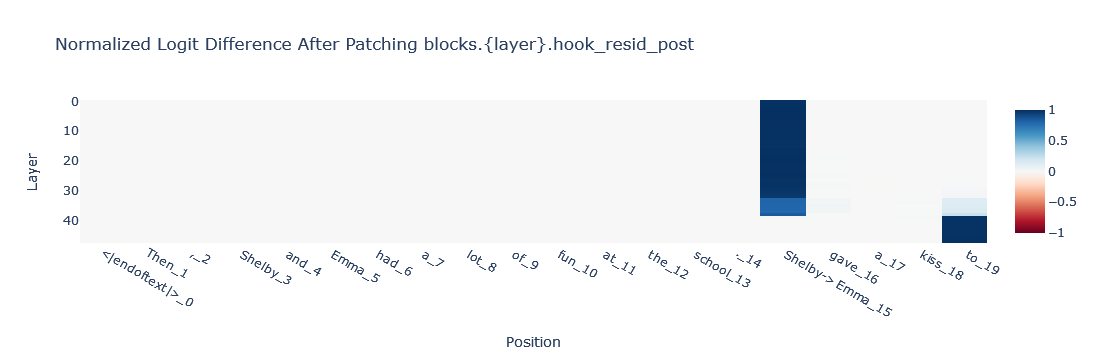

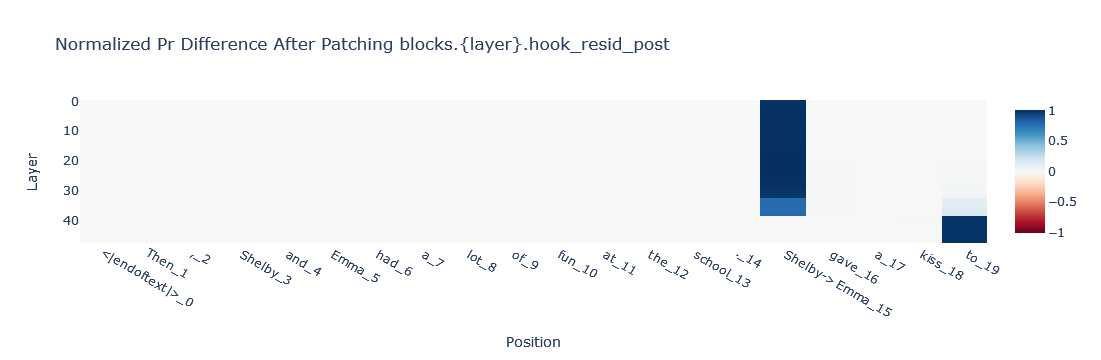

In [21]:
# useful for seeing the results of the most recent run
import plotly
name_func, hook_func = patching_types[choose_patching_type.patching_type]
hook_title = name_func(layer='{layer}', position='{pos}')
imshow(patching_result_logits, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Logit Difference After Patching {hook_title}")
imshow(patching_result_prs, x=token_labels, xaxis="Position", yaxis="Layer", title=f"Normalized Pr Difference After Patching {hook_title}")

In [58]:


from docstring import docstring_prompt_generator_function
docstring_ind_prompt_kwargs = dict(
    n_matching_args=3, n_def_prefix_args=2, n_def_suffix_args=1, n_doc_prefix_args=0, met_desc_len=3, arg_desc_len=2
)

prompt = docstring_induction_prompt_generator("rest", **docstring_ind_prompt_kwargs, seed=seed)
print("original prompt")
print(prompt.clean_prompt)

# random_doc replaces the names in the docstring with random things (probably things not even in the definition)
# random_def replaces the names in the definition before the output name with random strs
# random_answer replaces the name in the definition with a random one

for k in prompt.corrupt_prompt.keys():
    print(k)
    print(prompt.corrupt_prompt[k])
print(prompt)


original prompt

def count(self, query, names, load, content, obj, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_doc

def count(self, query, names, load, content, obj, shape):
    """middle floor payment

    :param user: bar editor
    :param context: material win
    :param
random_def

def count(self, query, names, user, context, obj, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_answer

def count(self, query, names, load, content, first, shape):
    """middle floor payment

    :param load: bar editor
    :param content: material win
    :param
random_def_doc

def count(self, query, names, user, context, obj, shape):
    """middle floor payment

    :param user: bar editor
    :param context: material win
    :param
random_answer_doc

def count(self, query, names, load, content, first, shape):
    """middle floor payment

    :param user: bar ed